# Card transaction prediction

#### **Task Description**
One of the most valuable sources of information about a customer is their banking transaction data. In this competition, participants are challenged to predict a customer's future spending, using information about their past spending.

#### **Goal**
Predict the next 10 transactions of a customer (mcc codes)

#### **Evaluation: MAP@10**

#### **Dataset Description**
* __df_train.csv__ - data for training a predictive algorithm.
* __df_test.csv__ - test dataset

#### **Data fields**

**df_train.csv**
* __data__ - customer spending history (sequence of MCC codes in chronological order)
* __target__ - the sequence of the client's future expenses

**df_test.csv**
* __Id__ - client ID
* __data__ - customer spending history (sequence of MCC codes in chronological order)

### Data loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fast')

In [3]:
df_train = pd.read_csv('df_train.csv', sep=';')
df_test = pd.read_csv('df_test.csv', sep=';')

In [4]:
df_train['Data'] = df_train.Data.apply(lambda s: list(map(int, s.split(','))))
df_train['Target'] = df_train.Target.apply(lambda s: list(map(int, s.split(','))))
df_test['Data'] = df_test.Data.apply(lambda s: list(map(int, s.split(','))))

In [5]:
df_train['Data'].head()

0    [4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...
1    [6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...
2    [8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...
3    [4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...
4    [4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...
Name: Data, dtype: object

### EDA

__Let's look at the distribution of the lengths of customer stories__

(0.0, 1000.0)

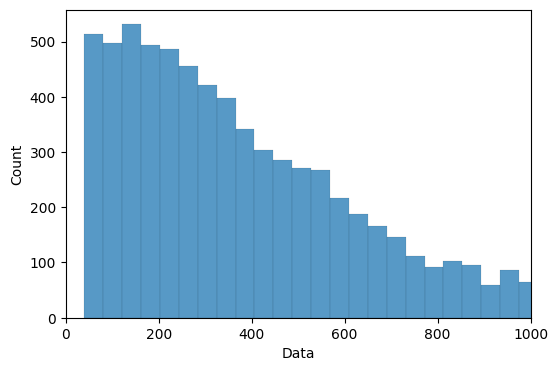

In [26]:
plt.figure(figsize=(6, 4), dpi=100)
sns.histplot(df_train.Data.apply(len))
plt.xlim(right=1000)
plt.xlim(left=0)

__Look at the shortest and longest stories__

In [7]:
number_of_transactions_train = df_train.Data.apply(len).sort_values(ascending=False)
number_of_transactions_test = df_test.Data.apply(len).sort_values(ascending=False)
number_of_transactions_train.head()

4210    21101
2451    19177
538     18994
1774    15396
807     15196
Name: Data, dtype: int64

In [8]:
number_of_transactions_train.tail()

4924    40
5842    40
7018    40
3266    40
745     40
Name: Data, dtype: int64

__Here are some statistical tests__

Because the solution will be presented in the form of a deterministic function that performs prediction by calculating statistics on a sequence of operations.

Testing the hypothesis of equality of averages and the same distribution is important because function manipulates the data from the train sample and will work in the same way with the test sample.

**Is the distribution normal?**

For this purpose, we will use the Shapiro-Wilk test:  
***The Shapiro-Wilk test*** is used to test the hypothesis $H_0$:
"the random variable $X$ is normally distributed"
 and is one of the most effective criteria for testing normality.

In [9]:
shapiro_train = stats.shapiro(number_of_transactions_train)
shapiro_train

ShapiroResult(statistic=0.3093855381011963, pvalue=0.0)

We look at `pvalue` - this is the probability, if the null hypothesis is true, of getting the same value of the observed statistic or even more extreme.\
We have `pvalue = 0.0`, so the hypothesis is rejected

__Then let's take a look at the graphs and see for ourselves__

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


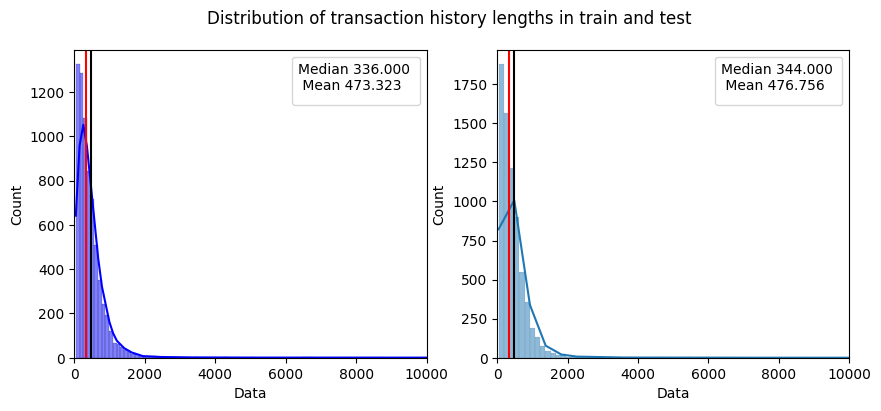

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=100)
sns.histplot(
    (number_of_transactions_train),
    ax=axes[0],
    bins=200,
    color = 'b' ,
    kde=True);
sns.histplot(
    (number_of_transactions_test),
    ax=axes[1],
    bins=600,
    kde=True);

fig.suptitle("Distribution of transaction history lengths in train and test")

axes[0].legend(title="Median {:.3f} \n Mean {:.3f}".format(
              (np.median(number_of_transactions_train)),
              (number_of_transactions_train.mean())),
              loc="upper right", 
              fontsize='medium');
axes[0].axvline(np.median(number_of_transactions_train), color='r')
axes[0].axvline(number_of_transactions_train.mean(), color='black')
axes[0].set_ylabel("Count")
axes[0].set_xlim(0, 10000);

axes[1].legend(title="Median {:.3f} \n Mean {:.3f}".format(
              (np.median(number_of_transactions_test)),
              (number_of_transactions_test.mean())),
              loc="upper right", 
              fontsize='medium');
axes[1].axvline((np.median(number_of_transactions_test)), color='r')
axes[1].axvline((number_of_transactions_test.mean()), color='black')
axes[1].set_ylabel("Count")
axes[1].set_xlim(0, 10000);

More like $\chi^2_{n}$.\
Let's use Kolmogorov-Smirnov test.

***Kolmogorov-Smirnov test*** can be used to test whether a sample came from a given reference probability distribution.

$$
\begin{aligned}
H_0 : F(x) \sim \chi^2_{n} \\
H_1 : F(x) \nsim \chi^2_{n}
\end{aligned}
$$

In [11]:
stats.kstest(number_of_transactions_train, 'chi2', args=(number_of_transactions_train.mean(), number_of_transactions_train.std(ddof=1)))

KstestResult(statistic=0.9562916034388173, pvalue=0.0, statistic_location=1197, statistic_sign=1)

Again, we have `pvalue = 0.0`, so the hypothesis is rejected

Let's apply the Box-Cox transformation.

$$
\begin{aligned}  
 y_i^{\lambda} = \begin{cases}\frac{(y_i+\alpha)^{\lambda}-1}{\lambda},&\text{if } \lambda \neq 0,\\ \log{(y_i+\alpha)},& \text{if } \lambda = 0.\end{cases}
\end{aligned}
$$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$log$')

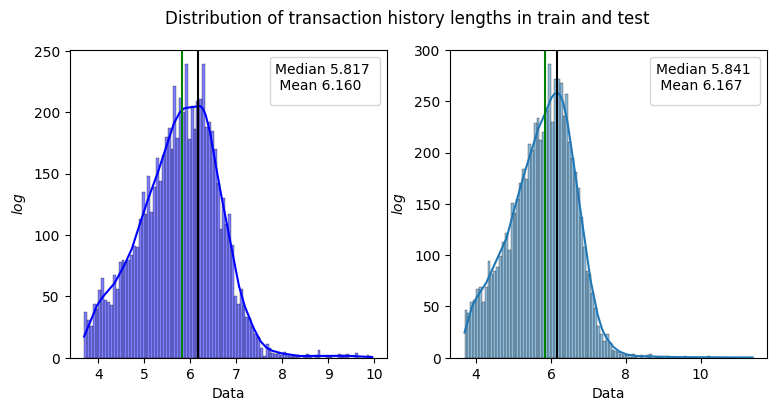

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), dpi=100)
sns.histplot(
    np.log(number_of_transactions_train),
    ax=axes[0],
    bins=100,
    color = 'b' ,
    kde=True);
sns.histplot(
    np.log(number_of_transactions_test),
    ax=axes[1],
    bins=100,
    kde=True);

fig.suptitle("Distribution of transaction history lengths in train and test")

axes[0].legend(title="Median {:.3f} \n Mean {:.3f}".format(
              np.log(np.median(number_of_transactions_train)),
              np.log(number_of_transactions_train.mean())),
              loc="upper right")
axes[0].axvline(np.log(np.median(number_of_transactions_train)), color='g')
axes[0].axvline(np.log(number_of_transactions_train.mean()), color='black')
axes[0].set_ylabel("$log$")

axes[1].legend(title="Median {:.3f} \n Mean {:.3f}".format(
              np.log(np.median(number_of_transactions_test)),
              np.log(number_of_transactions_test.mean())),
              loc="upper right")
axes[1].axvline(np.log(np.median(number_of_transactions_test)), color='g')
axes[1].axvline(np.log(number_of_transactions_test.mean()), color='black')
axes[1].set_ylabel("$log$")

**Two-sample K–S test**

$$
\begin{aligned}
H_0 : X_1 \sim X_2 \\
H_1 : X_1 \nsim X_2
\end{aligned}
$$

In [14]:
stats.ks_2samp(number_of_transactions_train, number_of_transactions_test)

KstestResult(statistic=0.01635148585241007, pvalue=0.303985536729003, statistic_location=372, statistic_sign=1)

We see that $p\_value$ is higher than $5\%$, so the hypothesis is not rejected.

* Hypothesis: The average length of the sequence in train and test are equal

Testing the hypothesis of equality of averages. The samples are independent. $alpha=5$

$$
\begin{aligned}
&H_0: \hspace{2mm} m_1 = m_2 \hspace{2mm} \text{The averages are equal} \\
&H_1: \hspace{2mm} m_1 \ne m_2 \hspace{2mm} \text{There are differences}
\end{aligned}
$$

In [27]:
alpha = 0.05
nx, ny = number_of_transactions_train.size, number_of_transactions_test.size

diff =  number_of_transactions_test.mean() -  number_of_transactions_train.mean()
diff_std = np.sqrt(number_of_transactions_train.var(ddof=1)/nx + number_of_transactions_test.var(ddof=1)/ny)

Asymptotic mean test

In [28]:
def asy_mean_test(mean_hat, std_hat, mu_0=0,
                   alpha=0.05, alternative='two-sided', margin=3):

    z_obs = (mean_hat - mu_0)/std_hat

    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
        z_crit = stats.norm().ppf(1 - alpha/2)

        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'),
                                        (z_crit, 0.05, z_crit, margin, 'b'),
                                        (-z_obs, -0.6, -margin, -z_obs, 'r'),
                                        (z_obs, 0.1, z_obs, margin, 'r')]))

    if alternative == 'less':
        p_value = stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)

        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)

        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))


    plt.figure(figsize = (10, 5))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]

    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]

        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin,
                 h*y_max, round(statistic, 2), color=color, fontsize=16)

        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)

    return f"pvalue {p_value}"

'pvalue 0.4271677367964686'

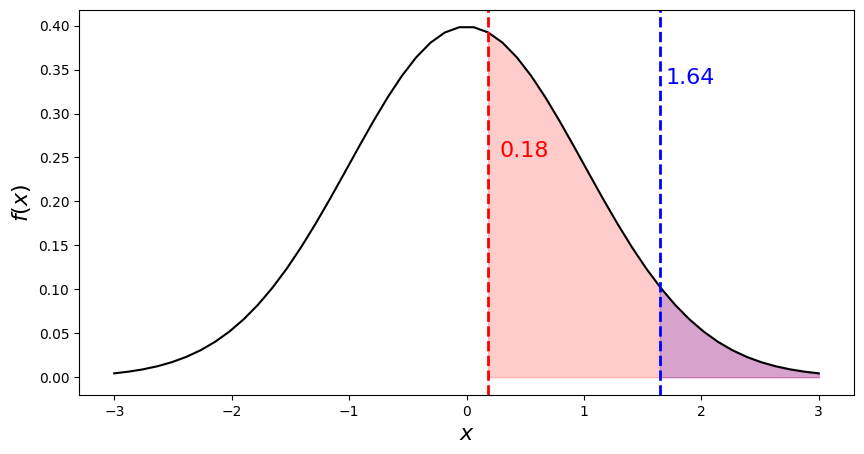

In [29]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='larger')

The null hypothesis is not rejected, the mean values are indeed close.

In [30]:
diff =  number_of_transactions_test.mean() -  number_of_transactions_train.mean()
diff

3.4332432816721052

### Predict function

__Chapters of writing a predicate function__.

1. `take_top10` - The most basic solution. It simply takes the top 10 mcc codes in history. Obviously, it is not an optimal solution, nevertheless I implemented the code, it allowed me to start from something.
2. Take into account the time component, i.e. I give newer transactions in the sequence more weight by taking into account their positions. For example, for the input sequence [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2] the output sequence will start at [2, 1 ...], because the sum of positions for a two (6+7+8=21) will be greater than for a one (1+2+3+4+5=15).